In [1]:
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

# Predictive Model Creation

This notebook builds a predictive model to estimate **solar power output (PVOUT)** using weather-based regressors derived from the Australian Daily Weather dataset.

The workflow includes:
- Handling multicollinearity through feature consolidation
- Evaluating multiple baseline regression models
- Implementing SimpleImpute and Standard Regularization
- Selecting and tuning an interpretable ElasticNet model using repeated cross-validation
- Analyzing feature importance via model coefficients

The focus is on producing a **robust, interpretable baseline model** that can estimate expected solar output given typical or user-specified weather conditions, rather than short-term forecasting.


# Load Data

In [2]:
df = pd.read_csv("dataset_train_only.csv")

df

,Location,n_obs,MinTemp_mean,MaxTemp_mean,Temp9am_mean,Temp3pm_mean,Humidity9am_mean,Humidity3pm_mean,Pressure9am_mean,Pressure3pm_mean,Cloud9am_mean,Cloud3pm_mean,WindGustSpeed_mean,WindSpeed9am_mean,WindSpeed3pm_mean,Rainfall_mean,Evaporation_mean,Sunshine_mean,pvout_mean
0,Adelaide,2178,12.525310,22.781066,16.831494,21.449425,60.069885,44.996780,1018.711551,1016.777773,NaN,NaN,36.503238,9.998160,15.519319,1.525542,5.756787,7.755278,4.384775
1,Albany,2051,12.901591,20.003744,16.196347,18.333291,74.835562,67.520886,1018.372616,1016.584562,5.176616,4.895833,NaN,12.536779,18.907702,2.208440,4.215546,6.629656,3.844816
2,Albury,2142,9.497053,22.529285,14.275105,21.260122,74.312004,48.103319,1018.382073,1015.760215,6.417749,5.476000,32.854733,8.200561,14.403648,2.039531,NaN,NaN,4.444959
3,AliceSprings,2119,13.219641,29.295517,21.379000,28.058263,39.834121,24.253901,1016.610104,1012.804487,2.867129,3.273656,40.460287,14.659112,18.018886,0.881268,9.024094,9.545709,5.246265
4,BadgerysCreek,2041,11.132579,23.962187,16.543886,22.464561,76.769955,51.163609,1018.577680,1015.764876,NaN,NaN,33.496796,8.088845,13.978744,2.115542,NaN,NaN,4.167959
5,Ballarat,2122,7.284866,18.234276,11.622196,16.760057,81.750831,58.847426,1018.170764,1016.554869,5.836900,6.285094,44.641940,19.880851,22.706604,1.523724,NaN,NaN,3.912061
6,Bendigo,2110,8.524550,21.429587,13.753791,20.067805,70.756167,46.859175,1018.058306,1015.922613,4.425000,4.858391,38.867499,12.971049,17.238253,1.556906,3.754054,NaN,4.357367
7,Brisbane,2202,16.374989,26.411874,21.802363,24.725114,63.857338,53.660438,1018.289373,1015.144389,3.917310,3.870059,28.229433,6.990917,10.955475,3.170340,5.413111,8.096908,4.356816
8,Cairns,2101,21.176868,29.532889,25.777535,27.880485,69.971918,61.711566,1014.122180,1011.070062,4.577157,4.430973,38.111537,15.966683,21.949048,5.661007,6.252295,7.584179,4.397265
9,Canberra,2393,6.790928,20.999749,12.663770,19.482991,73.111537,45.634075,1019.018837,1016.271793,4.887333,4.849426,39.959240,10.437360,19.101703,1.736176,4.470935,7.411939,4.528408


# Checking Feature Correlation

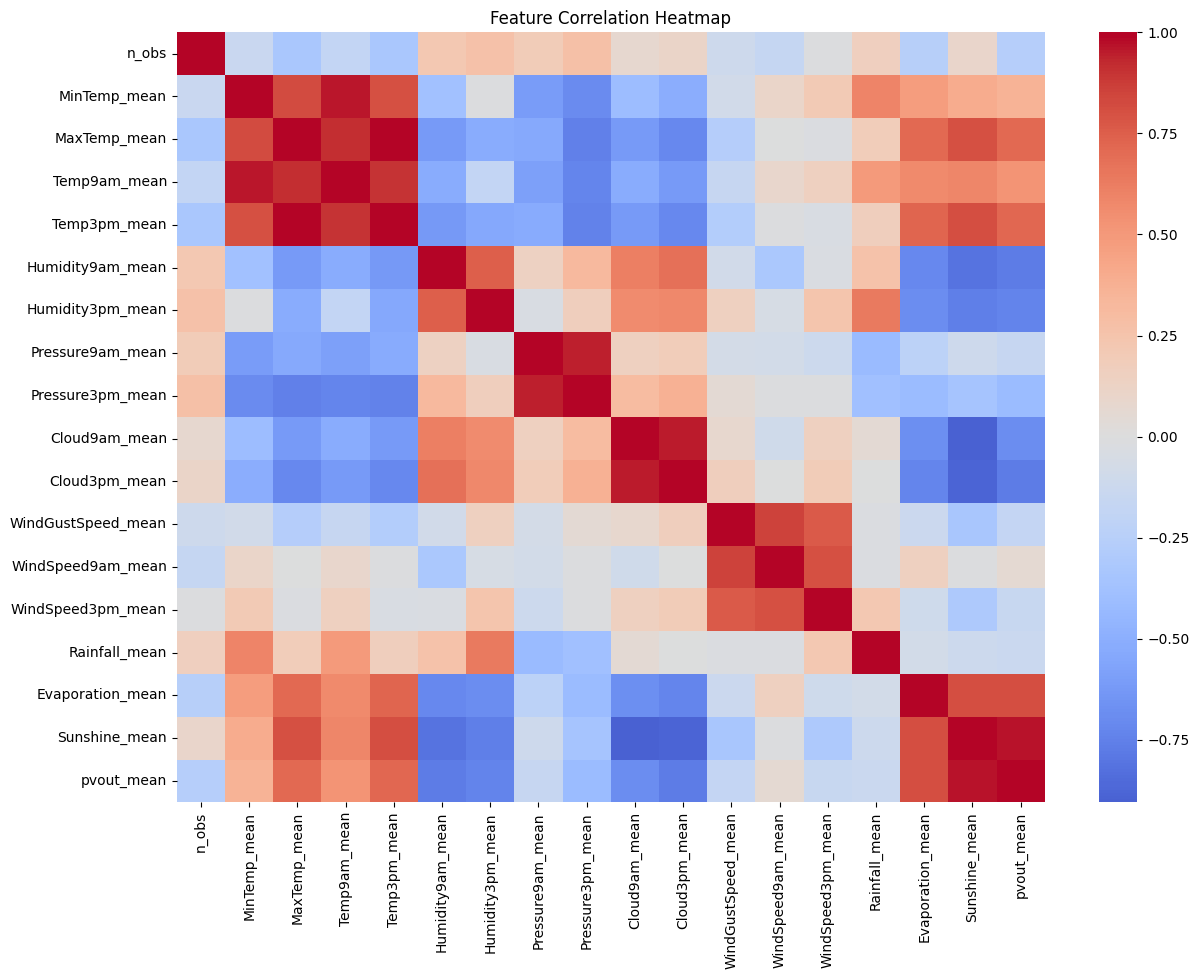

In [3]:
num_cols = df.select_dtypes(include="number").columns

plt.figure(figsize=(14, 10))
sns.heatmap(
    df[num_cols].corr(),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Feature Correlation Heatmap")
plt.show()


# Feature Engineering & Selection

In [4]:
df["temp_range"] = df["MaxTemp_mean"] - df["MinTemp_mean"]
df["humidity_avg"] = (df["Humidity9am_mean"] + df["Humidity3pm_mean"]) / 2
df["cloud_avg"] = (df["Cloud9am_mean"] + df["Cloud3pm_mean"]) / 2
df["pressure_avg"] = (df["Pressure9am_mean"] + df["Pressure3pm_mean"]) / 2
df["wind_speed_avg"] = (df["WindSpeed9am_mean"] + df["WindSpeed3pm_mean"]) / 2

In [5]:
TARGET = "pvout_mean"

DROP_COLS = [
    TARGET,
    "Location",
    "n_obs",

    # Temperature (collapsed into temp_range)
    "MinTemp_mean",
    "MaxTemp_mean",
    "Temp9am_mean",
    "Temp3pm_mean",

    # Humidity (collapsed into humidity_avg)
    "Humidity9am_mean",
    "Humidity3pm_mean",

    # Cloud (collapsed into cloud_avg)
    "Cloud9am_mean",
    "Cloud3pm_mean",

    # Pressure (collapsed into pressure_avg)
    "Pressure9am_mean",
    "Pressure3pm_mean",

    # Wind speed (collapsed into wind_speed_avg)
    "WindSpeed9am_mean",
    "WindSpeed3pm_mean",
]

df_model = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

df_model = df_model[df[TARGET].notna()].reset_index(drop=True)


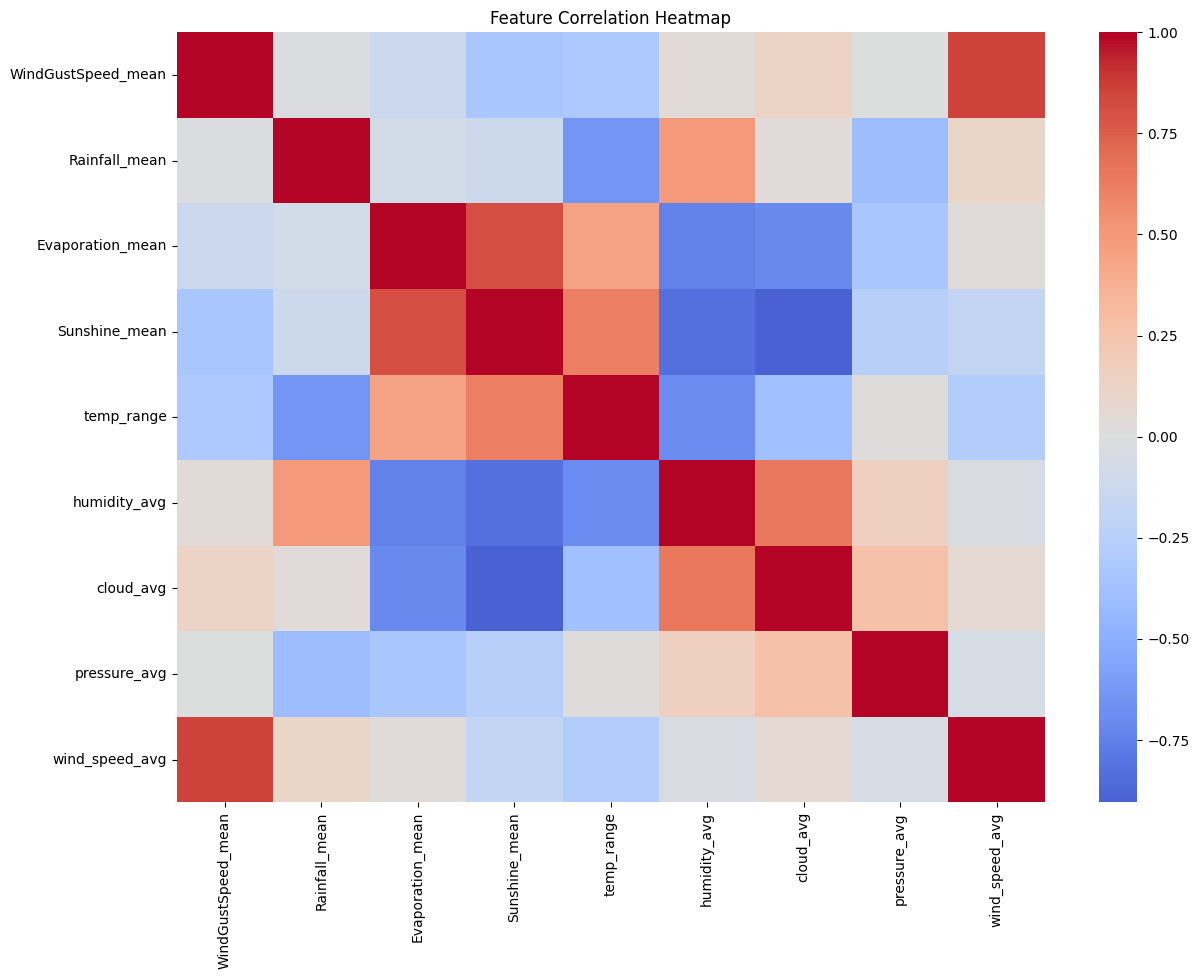

In [6]:
num_cols = df_model.select_dtypes(include="number").columns

plt.figure(figsize=(14, 10))
sns.heatmap(
    df[num_cols].corr(),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Feature Correlation Heatmap")
plt.show()

# Baseline Model Comparison

We first evaluated a range of baseline regression models using reasonable default settings to understand the underlying relationship between weather variables and solar output before any fine-tuning. 

Models spanning linear (Ridge, Lasso, ElasticNet) and non-linear approaches (SVR, Random Forest, Gradient Boosting, XGBoost when available) were compared using repeated 5-fold cross-validation to ensure stable estimates. 

Imputation and scaling were performed within each fold to avoid data leakage, and models were ranked primarily by mean absolute error (MAE). This step allowed us to identify strong candidate models and assess whether additional complexity meaningfully improved performance prior to optimization.

In [7]:
X = df_model.drop(columns=[TARGET], errors="ignore")
y = df[TARGET].astype(float)

In [8]:

RANDOM_STATE = 42
cv = RepeatedKFold(n_splits=5, n_repeats=50, random_state=RANDOM_STATE)

scoring = {
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "r2": make_scorer(r2_score),
}

def eval_pipe(name, pipe, X, y, cv):
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    mae = -scores["test_mae"]
    r2 = scores["test_r2"]
    return {
        "model": name,
        "mae_mean": mae.mean(),
        "mae_std": mae.std(),
        "r2_mean": r2.mean(),
        "r2_std": r2.std(),
    }

# Pipelines (impute inside CV = no leakage)
pipes = {
    "Ridge": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
    ]),
    "Lasso": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("model", Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=20000)),
    ]),
    "ElasticNet": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("model", ElasticNet(alpha=0.05, l1_ratio=0.3, random_state=RANDOM_STATE, max_iter=20000)),
    ]),
    "SVR_RBF": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("model", SVR(C=10.0, epsilon=0.05, gamma="scale")),
    ]),
    "RandomForest": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=500,
            random_state=RANDOM_STATE,
            min_samples_leaf=2,
        )),
    ]),
    "HGBR": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingRegressor(
            random_state=RANDOM_STATE,
            max_depth=3,
            learning_rate=0.05,
            max_iter=500,
        )),
    ]),
    
}

try:

    pipes["XGBoost"] = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            random_state=RANDOM_STATE,
            n_estimators=1000,
            learning_rate=0.03,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            reg_alpha=0.0,
            objective="reg:squarederror",
        )),
    ])

    pipes["GBM"] = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model", GradientBoostingRegressor(
            random_state=RANDOM_STATE,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
        )),
    ])

    print("XGBoost & GBM: enabled")

except Exception as e:
    print("XGBoost / GBM not available (skip). Reason:", repr(e))

results = []
for name, pipe in pipes.items():
    results.append(eval_pipe(name, pipe, X, y, cv))

leaderboard = (
    pd.DataFrame(results)
    .sort_values(["mae_mean"], ascending=True)
    .reset_index(drop=True)
)

leaderboard

XGBoost & GBM: enabled


,model,mae_mean,mae_std,r2_mean,r2_std
0,Lasso,0.136443,0.035368,0.755781,0.150789
1,ElasticNet,0.136648,0.036082,0.749036,0.160055
2,Ridge,0.142401,0.035534,0.737926,0.174881
3,GBM,0.148924,0.043545,0.703597,0.192364
4,XGBoost,0.155909,0.040764,0.686746,0.198667
5,RandomForest,0.156462,0.042304,0.676543,0.188789
6,SVR_RBF,0.176169,0.044118,0.626691,0.193571
7,HGBR,0.326481,0.074506,-0.160054,0.255954


# Hyperparameter Tuning (Optuna)

After selecting the strongest baseline candidates, we performed lightweight hyperparameter tuning with **Optuna** for the linear models (Ridge, ElasticNet, Lasso) to reduce MAE while keeping the approach robust for a small dataset. 

Each Optuna trial builds a full sklearn **Pipeline** (median imputation + standard scaling + model) and evaluates it using the same **RepeatedKFold (5 splits × 50 repeats)** scheme; the objective minimizes **cross-validated MAE** (converted back to a positive value). 

We then re-instantiated the best-performing pipelines using the optimal parameters found by Optuna and reported final cross-validated MAE (and R² for the selected ElasticNet model) using the same CV setup for an apples-to-apples comparison.


In [9]:
cv = RepeatedKFold(n_splits=5, n_repeats=50, random_state=RANDOM_STATE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def cv_mae_repeated(model, X, y, cv):
    """
    Returns mean MAE across CV folds (positive).
    Works with RepeatedKFold.
    """
    out = cross_validate(
        model,
        X, y,
        cv=cv,
        scoring={"mae": mae_scorer},
        n_jobs=-1,
        return_train_score=False,
    )
    # out["test_mae"] is negative; flip sign to get positive MAE
    return float(-np.mean(out["test_mae"]))

# Progress Print
def print_progress(study, trial):
    is_new_best = (study.best_trial.number == trial.number)
    if is_new_best or ((trial.number + 1) % 10 == 0):
        print(
            f"[{trial.number + 1}] "
            f"best MAE={study.best_value:.5f} | trial MAE={trial.value:.5f}"
        )
        if is_new_best:
            print(f"  NEW BEST params: {trial.params}")

# Ridge
def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=alpha, random_state=RANDOM_STATE)),
    ])

    return cv_mae_repeated(model, X, y, cv)

# ElasticNet
def objective_elasticnet(trial):
    alpha = trial.suggest_float("alpha", 1e-5, 1e1, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=RANDOM_STATE,
            max_iter=20000
        )),
    ])

    return cv_mae_repeated(model, X, y, cv)

# Lasso
def objective_lasso(trial):
    alpha = trial.suggest_float("alpha", 1e-5, 1e1, log=True)

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Lasso(
            alpha=alpha,
            random_state=RANDOM_STATE,
            max_iter=20000
        )),
    ])

    return cv_mae_repeated(model, X, y, cv)



In [10]:
# Run Optuna
study_ridge = optuna.create_study(direction="minimize", study_name="ridge_mae")
study_en    = optuna.create_study(direction="minimize", study_name="elasticnet_mae")
study_lasso = optuna.create_study(direction="minimize", study_name="lasso_mae")

study_ridge.optimize(objective_ridge, n_trials=200, callbacks=[print_progress])
study_en.optimize(objective_elasticnet, n_trials=200, callbacks=[print_progress])
study_lasso.optimize(objective_lasso, n_trials=200, callbacks=[print_progress])

# Print Summary
def print_study_summary(name, study):
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Best MAE: {study.best_value:.6f}")
    print("Best params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

print_study_summary("Ridge", study_ridge)
print_study_summary("ElasticNet", study_en)
print_study_summary("Lasso", study_lasso)

[I 2026-01-21 11:21:31,568] A new study created in memory with name: ridge_mae
[I 2026-01-21 11:21:31,569] A new study created in memory with name: elasticnet_mae
[I 2026-01-21 11:21:31,569] A new study created in memory with name: lasso_mae
[I 2026-01-21 11:21:31,734] Trial 0 finished with value: 0.26520471215187574 and parameters: {'alpha': 374.3259168373864}. Best is trial 0 with value: 0.26520471215187574.
[I 2026-01-21 11:21:31,888] Trial 1 finished with value: 0.1462131307953872 and parameters: {'alpha': 32.53593761357225}. Best is trial 1 with value: 0.1462131307953872.


[1] best MAE=0.26520 | trial MAE=0.26520
  NEW BEST params: {'alpha': 374.3259168373864}
[2] best MAE=0.14621 | trial MAE=0.14621
  NEW BEST params: {'alpha': 32.53593761357225}


[I 2026-01-21 11:21:32,042] Trial 2 finished with value: 0.1483042659649295 and parameters: {'alpha': 0.00010635493238086547}. Best is trial 1 with value: 0.1462131307953872.
[I 2026-01-21 11:21:32,201] Trial 3 finished with value: 0.22133484045566956 and parameters: {'alpha': 157.15241715536965}. Best is trial 1 with value: 0.1462131307953872.
[I 2026-01-21 11:21:32,354] Trial 4 finished with value: 0.14822781196930698 and parameters: {'alpha': 0.009871085998237716}. Best is trial 1 with value: 0.1462131307953872.
[I 2026-01-21 11:21:32,509] Trial 5 finished with value: 0.29457108111327135 and parameters: {'alpha': 859.6327855498557}. Best is trial 1 with value: 0.1462131307953872.
[I 2026-01-21 11:21:32,660] Trial 6 finished with value: 0.147797566914087 and parameters: {'alpha': 0.06614610554647993}. Best is trial 1 with value: 0.1462131307953872.
[I 2026-01-21 11:21:32,816] Trial 7 finished with value: 0.14828234020040404 and parameters: {'alpha': 0.0029022997234454807}. Best is tr

[10] best MAE=0.14621 | trial MAE=0.14804
[11] best MAE=0.13565 | trial MAE=0.13565
  NEW BEST params: {'alpha': 4.837974008325724}


[I 2026-01-21 11:21:33,434] Trial 11 finished with value: 0.13600284250190003 and parameters: {'alpha': 4.295079221516132}. Best is trial 10 with value: 0.13565462920896934.
[I 2026-01-21 11:21:33,581] Trial 12 finished with value: 0.13860138199619285 and parameters: {'alpha': 2.2107210934831243}. Best is trial 10 with value: 0.13565462920896934.
[I 2026-01-21 11:21:33,742] Trial 13 finished with value: 0.13964919354420416 and parameters: {'alpha': 1.797158701681913}. Best is trial 10 with value: 0.13565462920896934.
[I 2026-01-21 11:21:33,898] Trial 14 finished with value: 0.1346554445728663 and parameters: {'alpha': 8.529407045189739}. Best is trial 14 with value: 0.1346554445728663.
[I 2026-01-21 11:21:34,063] Trial 15 finished with value: 0.13463028671218988 and parameters: {'alpha': 12.829651274544045}. Best is trial 15 with value: 0.13463028671218988.


[15] best MAE=0.13466 | trial MAE=0.13466
  NEW BEST params: {'alpha': 8.529407045189739}
[16] best MAE=0.13463 | trial MAE=0.13463
  NEW BEST params: {'alpha': 12.829651274544045}


[I 2026-01-21 11:21:34,221] Trial 16 finished with value: 0.13768922290105762 and parameters: {'alpha': 21.21053029011253}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:34,381] Trial 17 finished with value: 0.14536088431501593 and parameters: {'alpha': 0.42968108849825154}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:34,547] Trial 18 finished with value: 0.14421734713218354 and parameters: {'alpha': 30.159518682653054}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:34,719] Trial 19 finished with value: 0.14575793818926974 and parameters: {'alpha': 0.36534484514501686}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:34,870] Trial 20 finished with value: 0.13543750054493603 and parameters: {'alpha': 16.497060048415072}. Best is trial 15 with value: 0.13463028671218988.


[20] best MAE=0.13463 | trial MAE=0.14576


[I 2026-01-21 11:21:35,025] Trial 21 finished with value: 0.13629430268213955 and parameters: {'alpha': 18.5377118947932}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:35,179] Trial 22 finished with value: 0.2025855329344649 and parameters: {'alpha': 112.01583857106375}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:35,336] Trial 23 finished with value: 0.14314347993356807 and parameters: {'alpha': 0.8399752334529831}. Best is trial 15 with value: 0.13463028671218988.
[I 2026-01-21 11:21:35,489] Trial 24 finished with value: 0.13452641763981057 and parameters: {'alpha': 9.79631403683559}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:35,643] Trial 25 finished with value: 0.1475693839245767 and parameters: {'alpha': 0.09700279990577941}. Best is trial 24 with value: 0.13452641763981057.


[25] best MAE=0.13453 | trial MAE=0.13453
  NEW BEST params: {'alpha': 9.79631403683559}


[I 2026-01-21 11:21:35,794] Trial 26 finished with value: 0.13485272796080555 and parameters: {'alpha': 7.389483376196374}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:35,942] Trial 27 finished with value: 0.16680620956685682 and parameters: {'alpha': 55.401118331081456}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:36,090] Trial 28 finished with value: 0.14140562273261656 and parameters: {'alpha': 1.2487456850171992}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:36,249] Trial 29 finished with value: 0.1347478580628142 and parameters: {'alpha': 7.953557474234449}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:36,404] Trial 30 finished with value: 0.28471823202510416 and parameters: {'alpha': 620.9418697000858}. Best is trial 24 with value: 0.13452641763981057.


[30] best MAE=0.13453 | trial MAE=0.13475


[I 2026-01-21 11:21:36,560] Trial 31 finished with value: 0.1349193190729972 and parameters: {'alpha': 7.0546493052437516}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:36,718] Trial 32 finished with value: 0.187235936268812 and parameters: {'alpha': 83.98124479520266}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:36,876] Trial 33 finished with value: 0.13468030657762445 and parameters: {'alpha': 8.352677366619751}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:37,030] Trial 34 finished with value: 0.26074746812279853 and parameters: {'alpha': 338.60903902449763}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:37,191] Trial 35 finished with value: 0.14830330873557454 and parameters: {'alpha': 0.00022834547603046586}. Best is trial 24 with value: 0.13452641763981057.
[I 2026-01-21 11:21:37,347] Trial 36 finished with value: 0.16636038002441078 and parameters: {'alpha': 54.86527908888042}. Be

[40] best MAE=0.13453 | trial MAE=0.13746
[41] best MAE=0.13451 | trial MAE=0.13451
  NEW BEST params: {'alpha': 11.390621108460746}


[I 2026-01-21 11:21:38,109] Trial 41 finished with value: 0.13451202850901264 and parameters: {'alpha': 10.027956522786484}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:38,256] Trial 42 finished with value: 0.13455932498686676 and parameters: {'alpha': 12.168285279790128}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:38,416] Trial 43 finished with value: 0.14716484668404417 and parameters: {'alpha': 33.64100580315637}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:38,574] Trial 44 finished with value: 0.2331386249381309 and parameters: {'alpha': 194.88794421428165}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:38,738] Trial 45 finished with value: 0.13759145415087473 and parameters: {'alpha': 2.7337491322491907}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:38,890] Trial 46 finished with value: 0.13494843940591295 and parameters: {'alpha': 14.842813596784897}. Best is

[50] best MAE=0.13451 | trial MAE=0.13652


[I 2026-01-21 11:21:39,701] Trial 51 finished with value: 0.13455737441295204 and parameters: {'alpha': 12.146440764140072}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:39,866] Trial 52 finished with value: 0.13458833225788694 and parameters: {'alpha': 12.463592504453835}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:40,029] Trial 53 finished with value: 0.17650735911685833 and parameters: {'alpha': 67.9155519785384}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:40,177] Trial 54 finished with value: 0.13602521099598835 and parameters: {'alpha': 4.262971450895829}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:40,386] Trial 55 finished with value: 0.14107980504192 and parameters: {'alpha': 26.204583131370722}. Best is trial 40 with value: 0.1345106730071562.
[I 2026-01-21 11:21:40,545] Trial 56 finished with value: 0.1345079038390199 and parameters: {'alpha': 11.318635557418938}. Best is tria

[57] best MAE=0.13451 | trial MAE=0.13451
  NEW BEST params: {'alpha': 11.318635557418938}


[I 2026-01-21 11:21:40,853] Trial 58 finished with value: 0.14418959650158641 and parameters: {'alpha': 0.6358168045329583}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,010] Trial 59 finished with value: 0.1482908950216961 and parameters: {'alpha': 0.0018109777470736962}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,156] Trial 60 finished with value: 0.2576255306885256 and parameters: {'alpha': 316.4016509826589}. Best is trial 56 with value: 0.1345079038390199.


[60] best MAE=0.13451 | trial MAE=0.14829


[I 2026-01-21 11:21:41,304] Trial 61 finished with value: 0.13460435136696447 and parameters: {'alpha': 12.604510424320635}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,456] Trial 62 finished with value: 0.13471933150733634 and parameters: {'alpha': 13.552578860106642}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,610] Trial 63 finished with value: 0.13511234584858078 and parameters: {'alpha': 6.206977586972798}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,760] Trial 64 finished with value: 0.1396627400261742 and parameters: {'alpha': 1.7922870992069309}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:41,914] Trial 65 finished with value: 0.1385599937473559 and parameters: {'alpha': 22.65846175465433}. Best is trial 56 with value: 0.1345079038390199.
[I 2026-01-21 11:21:42,066] Trial 66 finished with value: 0.13579804666120773 and parameters: {'alpha': 4.600466062923721}. Best is tr

[68] best MAE=0.13450 | trial MAE=0.13450
  NEW BEST params: {'alpha': 10.504135900048269}


[I 2026-01-21 11:21:42,515] Trial 69 finished with value: 0.1932575039109455 and parameters: {'alpha': 94.18956983685347}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:42,676] Trial 70 finished with value: 0.14677833116557543 and parameters: {'alpha': 0.2094950300389283}. Best is trial 67 with value: 0.13450138223942848.


[70] best MAE=0.13450 | trial MAE=0.19326


[I 2026-01-21 11:21:42,838] Trial 71 finished with value: 0.1345102537500136 and parameters: {'alpha': 11.3799254614801}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:42,990] Trial 72 finished with value: 0.13466753045854335 and parameters: {'alpha': 8.439609404662091}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:43,137] Trial 73 finished with value: 0.139399117432746 and parameters: {'alpha': 23.92547342060454}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:43,289] Trial 74 finished with value: 0.1382760846239316 and parameters: {'alpha': 2.359137406413321}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:43,504] Trial 75 finished with value: 0.1345059799516474 and parameters: {'alpha': 11.25968637015348}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:43,658] Trial 76 finished with value: 0.13550246725111287 and parameters: {'alpha': 5.147570039584983}. Best is tria

[80] best MAE=0.13450 | trial MAE=0.13686


[I 2026-01-21 11:21:44,495] Trial 81 finished with value: 0.13724164704848163 and parameters: {'alpha': 20.4028357420079}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:44,659] Trial 82 finished with value: 0.13460605748638838 and parameters: {'alpha': 12.619379688924601}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:44,827] Trial 83 finished with value: 0.1345523044644094 and parameters: {'alpha': 9.460951355317077}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:44,996] Trial 84 finished with value: 0.1352215682054896 and parameters: {'alpha': 5.842532652557586}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:45,185] Trial 85 finished with value: 0.16539470868963288 and parameters: {'alpha': 53.714672134061544}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:45,363] Trial 86 finished with value: 0.13658316816402952 and parameters: {'alpha': 19.131198852222003}. Best i

[90] best MAE=0.13450 | trial MAE=0.13894


[I 2026-01-21 11:21:46,222] Trial 91 finished with value: 0.14526764597767539 and parameters: {'alpha': 31.428808006014055}. Best is trial 67 with value: 0.13450138223942848.
[I 2026-01-21 11:21:46,398] Trial 92 finished with value: 0.13450068836095205 and parameters: {'alpha': 10.596930314925633}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:46,573] Trial 93 finished with value: 0.13459386775289067 and parameters: {'alpha': 9.046654034606759}. Best is trial 92 with value: 0.13450068836095205.


[93] best MAE=0.13450 | trial MAE=0.13450
  NEW BEST params: {'alpha': 10.596930314925633}


[I 2026-01-21 11:21:46,743] Trial 94 finished with value: 0.13537446761628244 and parameters: {'alpha': 5.434542931877064}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:46,905] Trial 95 finished with value: 0.13564185741622542 and parameters: {'alpha': 17.033667975653774}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:47,071] Trial 96 finished with value: 0.1454200619357427 and parameters: {'alpha': 31.608321027733854}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:47,227] Trial 97 finished with value: 0.18639515992670483 and parameters: {'alpha': 82.62442370484166}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:47,387] Trial 98 finished with value: 0.14499142715495134 and parameters: {'alpha': 0.4923325106682461}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:47,551] Trial 99 finished with value: 0.13452566160036622 and parameters: {'alpha': 9.807025604072983}. Best

[100] best MAE=0.13450 | trial MAE=0.13453


[I 2026-01-21 11:21:47,869] Trial 101 finished with value: 0.13450225639468535 and parameters: {'alpha': 10.397307585994614}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:48,028] Trial 102 finished with value: 0.1357779977288813 and parameters: {'alpha': 17.366497176571478}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:48,186] Trial 103 finished with value: 0.1349471028119604 and parameters: {'alpha': 6.917483505217854}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:48,347] Trial 104 finished with value: 0.1359250254408909 and parameters: {'alpha': 4.409723965716891}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:48,540] Trial 105 finished with value: 0.13450090017827993 and parameters: {'alpha': 10.982421040627413}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:48,695] Trial 106 finished with value: 0.13954459567224028 and parameters: {'alpha': 24.136034248877618}.

[110] best MAE=0.13450 | trial MAE=0.13504


[I 2026-01-21 11:21:49,474] Trial 111 finished with value: 0.13450146537459745 and parameters: {'alpha': 11.045254542833847}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:49,635] Trial 112 finished with value: 0.1345159852410905 and parameters: {'alpha': 9.952379454916656}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:49,800] Trial 113 finished with value: 0.13452115052722535 and parameters: {'alpha': 11.62950563535773}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:49,955] Trial 114 finished with value: 0.14254960652420662 and parameters: {'alpha': 28.085616758127024}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:50,112] Trial 115 finished with value: 0.13458416342424856 and parameters: {'alpha': 12.42482184769052}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:50,271] Trial 116 finished with value: 0.13600601288812797 and parameters: {'alpha': 4.290456755733234}.

[120] best MAE=0.13450 | trial MAE=0.14153


[I 2026-01-21 11:21:51,071] Trial 121 finished with value: 0.13454801593744042 and parameters: {'alpha': 12.039697330878253}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:51,235] Trial 122 finished with value: 0.13864221281585862 and parameters: {'alpha': 22.78593730067325}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:51,387] Trial 123 finished with value: 0.13451778320431954 and parameters: {'alpha': 11.558126781356794}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:51,546] Trial 124 finished with value: 0.13495680402139437 and parameters: {'alpha': 6.870215909934087}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:51,699] Trial 125 finished with value: 0.13732163400334868 and parameters: {'alpha': 2.9159918926265163}. Best is trial 92 with value: 0.13450068836095205.
[I 2026-01-21 11:21:51,859] Trial 126 finished with value: 0.14914978824858643 and parameters: {'alpha': 35.88332360020908

[130] best MAE=0.13450 | trial MAE=0.13556


[I 2026-01-21 11:21:52,655] Trial 131 finished with value: 0.13449989498540185 and parameters: {'alpha': 10.786458531133555}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:52,810] Trial 132 finished with value: 0.2955945913354067 and parameters: {'alpha': 893.1299746392555}. Best is trial 131 with value: 0.13449989498540185.


[132] best MAE=0.13450 | trial MAE=0.13450
  NEW BEST params: {'alpha': 10.786458531133555}


[I 2026-01-21 11:21:52,961] Trial 133 finished with value: 0.13486636594265322 and parameters: {'alpha': 7.3208193006679325}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:53,132] Trial 134 finished with value: 0.13450511344743282 and parameters: {'alpha': 10.210343014936779}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:53,294] Trial 135 finished with value: 0.1363958153620257 and parameters: {'alpha': 3.772488147675586}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:53,459] Trial 136 finished with value: 0.14827918136178933 and parameters: {'alpha': 0.0033054033563308586}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:53,611] Trial 137 finished with value: 0.14129488241112556 and parameters: {'alpha': 26.47976933213483}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:53,772] Trial 138 finished with value: 0.13454587617289038 and parameters: {'alpha': 9.53432907

[140] best MAE=0.13450 | trial MAE=0.14830


[I 2026-01-21 11:21:54,242] Trial 141 finished with value: 0.13451703120582453 and parameters: {'alpha': 11.540847343157196}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:54,403] Trial 142 finished with value: 0.13489824073224788 and parameters: {'alpha': 7.160739044161896}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:54,564] Trial 143 finished with value: 0.13496474812634035 and parameters: {'alpha': 14.916486907179742}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:54,726] Trial 144 finished with value: 0.13543531677447165 and parameters: {'alpha': 5.293799911311337}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:54,881] Trial 145 finished with value: 0.13449997726925636 and parameters: {'alpha': 10.843348465708189}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:55,047] Trial 146 finished with value: 0.13809310559639593 and parameters: {'alpha': 21.900243801

[150] best MAE=0.13450 | trial MAE=0.13654


[I 2026-01-21 11:21:55,888] Trial 151 finished with value: 0.13450487435235933 and parameters: {'alpha': 10.219842502789554}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:56,040] Trial 152 finished with value: 0.13453718492262642 and parameters: {'alpha': 9.643861345454873}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:56,206] Trial 153 finished with value: 0.13475069436965 and parameters: {'alpha': 13.76717207858689}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:56,363] Trial 154 finished with value: 0.13460366088239648 and parameters: {'alpha': 8.960723869391714}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:56,514] Trial 155 finished with value: 0.13546006788384998 and parameters: {'alpha': 5.238689740051153}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:56,681] Trial 156 finished with value: 0.13532574839789477 and parameters: {'alpha': 16.18652271823093

[160] best MAE=0.13450 | trial MAE=0.13496


[I 2026-01-21 11:21:57,475] Trial 161 finished with value: 0.1345588604321112 and parameters: {'alpha': 12.163082323450435}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:57,630] Trial 162 finished with value: 0.13454331388590782 and parameters: {'alpha': 9.564721862026591}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:57,783] Trial 163 finished with value: 0.13555723183108756 and parameters: {'alpha': 16.816743241215203}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:57,941] Trial 164 finished with value: 0.1354703018618447 and parameters: {'alpha': 5.216641277312764}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:58,102] Trial 165 finished with value: 0.13481458094073673 and parameters: {'alpha': 7.5888316272599985}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:58,265] Trial 166 finished with value: 0.1345000061097677 and parameters: {'alpha': 10.739344424302

[170] best MAE=0.13450 | trial MAE=0.13469


[I 2026-01-21 11:21:59,052] Trial 171 finished with value: 0.13450405518268332 and parameters: {'alpha': 10.25482579256514}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:59,207] Trial 172 finished with value: 0.13516049818855475 and parameters: {'alpha': 6.034293537253033}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:59,364] Trial 173 finished with value: 0.1345008020737903 and parameters: {'alpha': 10.96958388995267}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:59,534] Trial 174 finished with value: 0.13451707536960295 and parameters: {'alpha': 11.541859799326035}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:59,693] Trial 175 finished with value: 0.1359786041314236 and parameters: {'alpha': 17.842592610227264}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:21:59,856] Trial 176 finished with value: 0.14383549933717651 and parameters: {'alpha': 29.695316070925

[180] best MAE=0.13450 | trial MAE=0.13476


[I 2026-01-21 11:22:00,707] Trial 181 finished with value: 0.13456317830325082 and parameters: {'alpha': 9.345394046056468}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:22:00,890] Trial 182 finished with value: 0.13450007104200196 and parameters: {'alpha': 10.716402678304993}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:22:01,090] Trial 183 finished with value: 0.13510336833632772 and parameters: {'alpha': 6.240936052061787}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:22:01,278] Trial 184 finished with value: 0.13453409322747467 and parameters: {'alpha': 11.84809535071774}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:22:01,474] Trial 185 finished with value: 0.13514289662284862 and parameters: {'alpha': 15.603163844907188}. Best is trial 131 with value: 0.13449989498540185.
[I 2026-01-21 11:22:01,664] Trial 186 finished with value: 0.13464840332668956 and parameters: {'alpha': 8.58417564590

[190] best MAE=0.13450 | trial MAE=0.13450


[I 2026-01-21 11:22:02,552] Trial 191 finished with value: 0.13449989305583845 and parameters: {'alpha': 10.775459553093704}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:02,736] Trial 192 finished with value: 0.13451676717253308 and parameters: {'alpha': 11.534800432309796}. Best is trial 191 with value: 0.13449989305583845.


[192] best MAE=0.13450 | trial MAE=0.13450
  NEW BEST params: {'alpha': 10.775459553093704}


[I 2026-01-21 11:22:02,907] Trial 193 finished with value: 0.13498980048637418 and parameters: {'alpha': 6.709666003209065}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:03,078] Trial 194 finished with value: 0.13537086654978367 and parameters: {'alpha': 16.314108857858663}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:03,234] Trial 195 finished with value: 0.13452378933917278 and parameters: {'alpha': 9.833510197647364}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:03,393] Trial 196 finished with value: 0.1348699173086575 and parameters: {'alpha': 7.303004123426847}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:03,561] Trial 197 finished with value: 0.1345827286992637 and parameters: {'alpha': 12.411418778156888}. Best is trial 191 with value: 0.13449989305583845.
[I 2026-01-21 11:22:03,722] Trial 198 finished with value: 0.1375769807190653 and parameters: {'alpha': 21.0143242962952

[200] best MAE=0.13450 | trial MAE=0.13538
[1] best MAE=0.14788 | trial MAE=0.14788
  NEW BEST params: {'alpha': 0.0001678292611433732, 'l1_ratio': 0.9383990787850982}


[I 2026-01-21 11:22:04,207] Trial 1 finished with value: 0.14828944055985166 and parameters: {'alpha': 2.288449530264729e-05, 'l1_ratio': 0.1572449858527908}. Best is trial 0 with value: 0.14788002268081882.
[I 2026-01-21 11:22:04,366] Trial 2 finished with value: 0.30741855774705723 and parameters: {'alpha': 0.611663951847665, 'l1_ratio': 0.4789592971311021}. Best is trial 0 with value: 0.14788002268081882.
[I 2026-01-21 11:22:04,525] Trial 3 finished with value: 0.16547228841733477 and parameters: {'alpha': 0.2348067300802691, 'l1_ratio': 0.28694524310009073}. Best is trial 0 with value: 0.14788002268081882.
[I 2026-01-21 11:22:04,685] Trial 4 finished with value: 0.14132203776962235 and parameters: {'alpha': 0.003509800595165983, 'l1_ratio': 0.9218388734957566}. Best is trial 4 with value: 0.14132203776962235.
[I 2026-01-21 11:22:04,850] Trial 5 finished with value: 0.1362325716708376 and parameters: {'alpha': 0.01573703773011224, 'l1_ratio': 0.7165939381741865}. Best is trial 5 wit

[5] best MAE=0.14132 | trial MAE=0.14132
  NEW BEST params: {'alpha': 0.003509800595165983, 'l1_ratio': 0.9218388734957566}
[6] best MAE=0.13623 | trial MAE=0.13623
  NEW BEST params: {'alpha': 0.01573703773011224, 'l1_ratio': 0.7165939381741865}


[I 2026-01-21 11:22:05,007] Trial 6 finished with value: 0.18272682483737654 and parameters: {'alpha': 0.2926890755913166, 'l1_ratio': 0.3086989869456972}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:05,166] Trial 7 finished with value: 0.14818502725874902 and parameters: {'alpha': 5.816266292386622e-05, 'l1_ratio': 0.7309152870852417}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:05,334] Trial 8 finished with value: 0.14826156556824294 and parameters: {'alpha': 1.6453709511397385e-05, 'l1_ratio': 0.9614515315438641}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:05,501] Trial 9 finished with value: 0.1418891350519011 and parameters: {'alpha': 0.05392258057719391, 'l1_ratio': 0.4356195115337588}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:05,670] Trial 10 finished with value: 0.32648091891125736 and parameters: {'alpha': 8.524781579612524, 'l1_ratio': 0.6921778110106933}. Best is trial 5 with 

[10] best MAE=0.13623 | trial MAE=0.14189


[I 2026-01-21 11:22:05,833] Trial 11 finished with value: 0.1440139822822821 and parameters: {'alpha': 0.0021950581268455373, 'l1_ratio': 0.7756154474881027}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:05,994] Trial 12 finished with value: 0.14399040043704273 and parameters: {'alpha': 0.0026428327851896138, 'l1_ratio': 0.6288763723574179}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:06,159] Trial 13 finished with value: 0.13633072584383205 and parameters: {'alpha': 0.012166941759868544, 'l1_ratio': 0.834653245129877}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:06,331] Trial 14 finished with value: 0.14076963177500532 and parameters: {'alpha': 0.02650963394164636, 'l1_ratio': 0.8091576430014524}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:06,487] Trial 15 finished with value: 0.14753646842907242 and parameters: {'alpha': 0.00044771505232176227, 'l1_ratio': 0.6025713471166076}. Best is tria

[20] best MAE=0.13623 | trial MAE=0.16587


[I 2026-01-21 11:22:07,437] Trial 21 finished with value: 0.13675413583931947 and parameters: {'alpha': 0.016755458979789643, 'l1_ratio': 0.825594181360739}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:07,597] Trial 22 finished with value: 0.13820434011361932 and parameters: {'alpha': 0.008335351803391277, 'l1_ratio': 0.6961532645386793}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:07,761] Trial 23 finished with value: 0.16840770057278923 and parameters: {'alpha': 0.08502055586280928, 'l1_ratio': 0.9932969923500804}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:07,923] Trial 24 finished with value: 0.14389854234666655 and parameters: {'alpha': 0.02891642397781979, 'l1_ratio': 0.8886251025904585}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:08,085] Trial 25 finished with value: 0.14649878697946878 and parameters: {'alpha': 0.000880200611080263, 'l1_ratio': 0.7597128650480567}. Best is trial 5 

[30] best MAE=0.13623 | trial MAE=0.14794


[I 2026-01-21 11:22:09,078] Trial 31 finished with value: 0.14223001528774507 and parameters: {'alpha': 0.028258117873557323, 'l1_ratio': 0.8314688073309919}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:09,246] Trial 32 finished with value: 0.13696205438695655 and parameters: {'alpha': 0.01759655082018846, 'l1_ratio': 0.8237478362532635}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:09,417] Trial 33 finished with value: 0.1395441969578103 and parameters: {'alpha': 0.004659121344571145, 'l1_ratio': 0.9978103339675894}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:09,581] Trial 34 finished with value: 0.1362600023863966 and parameters: {'alpha': 0.01562000950072517, 'l1_ratio': 0.7350696492887882}. Best is trial 5 with value: 0.1362325716708376.
[I 2026-01-21 11:22:09,742] Trial 35 finished with value: 0.15318997051653072 and parameters: {'alpha': 0.06214053867931472, 'l1_ratio': 0.648595699565004}. Best is trial 5 wit

[40] best MAE=0.13623 | trial MAE=0.32589


[I 2026-01-21 11:22:10,719] Trial 41 finished with value: 0.13622536951111414 and parameters: {'alpha': 0.014457517966496239, 'l1_ratio': 0.7251150639220981}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:10,884] Trial 42 finished with value: 0.14053782010670546 and parameters: {'alpha': 0.010369527367435068, 'l1_ratio': 0.2931961467805564}. Best is trial 41 with value: 0.13622536951111414.


[42] best MAE=0.13623 | trial MAE=0.13623
  NEW BEST params: {'alpha': 0.014457517966496239, 'l1_ratio': 0.7251150639220981}


[I 2026-01-21 11:22:11,045] Trial 43 finished with value: 0.14673717306334993 and parameters: {'alpha': 0.03996268231763291, 'l1_ratio': 0.7361811223710768}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:11,213] Trial 44 finished with value: 0.14114051583444484 and parameters: {'alpha': 0.004458427767469084, 'l1_ratio': 0.7307117849139427}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:11,375] Trial 45 finished with value: 0.13694794608191382 and parameters: {'alpha': 0.015195258079419228, 'l1_ratio': 0.9435010382843466}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:11,546] Trial 46 finished with value: 0.17354566154787965 and parameters: {'alpha': 0.13645897168238813, 'l1_ratio': 0.6411783864050596}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:11,716] Trial 47 finished with value: 0.14100590990580314 and parameters: {'alpha': 0.047165874790909716, 'l1_ratio': 0.4690438877558754}. Best is

[50] best MAE=0.13623 | trial MAE=0.13924


[I 2026-01-21 11:22:12,378] Trial 51 finished with value: 0.14010274954229351 and parameters: {'alpha': 0.01562973091284443, 'l1_ratio': 0.17950678699289824}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:12,546] Trial 52 finished with value: 0.13728844406114296 and parameters: {'alpha': 0.018549850309758337, 'l1_ratio': 0.8303213095900052}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:12,708] Trial 53 finished with value: 0.13638891008849294 and parameters: {'alpha': 0.012195492820272807, 'l1_ratio': 0.7888500163254275}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:12,866] Trial 54 finished with value: 0.1369928099181638 and parameters: {'alpha': 0.010939582691896533, 'l1_ratio': 0.6932012660759025}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:13,037] Trial 55 finished with value: 0.1427575399741944 and parameters: {'alpha': 0.002936527046435001, 'l1_ratio': 0.7908063347933406}. Best is

[60] best MAE=0.13623 | trial MAE=0.13791


[I 2026-01-21 11:22:14,055] Trial 61 finished with value: 0.13920210308627992 and parameters: {'alpha': 0.023315674094327464, 'l1_ratio': 0.8204692925511134}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:14,221] Trial 62 finished with value: 0.1365960007290716 and parameters: {'alpha': 0.011355138167302391, 'l1_ratio': 0.7674886944855707}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:14,383] Trial 63 finished with value: 0.1367002449028811 and parameters: {'alpha': 0.010715904517333372, 'l1_ratio': 0.7878911438800894}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:14,545] Trial 64 finished with value: 0.14016951233733235 and parameters: {'alpha': 0.005271320641221184, 'l1_ratio': 0.7563709517224319}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:14,708] Trial 65 finished with value: 0.13655663553545908 and parameters: {'alpha': 0.012208021285614108, 'l1_ratio': 0.7103001903937867}. Best is

[70] best MAE=0.13623 | trial MAE=0.13760


[I 2026-01-21 11:22:15,675] Trial 71 finished with value: 0.1368823742094925 and parameters: {'alpha': 0.010936524621325746, 'l1_ratio': 0.7179502044282969}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:15,830] Trial 72 finished with value: 0.1365344998085687 and parameters: {'alpha': 0.01520791427547215, 'l1_ratio': 0.8514718200486845}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:16,005] Trial 73 finished with value: 0.14134320031286618 and parameters: {'alpha': 0.0037712622168299837, 'l1_ratio': 0.8455498760237151}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:16,164] Trial 74 finished with value: 0.14543350662633567 and parameters: {'alpha': 0.034134567191082925, 'l1_ratio': 0.8104455809928488}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:16,352] Trial 75 finished with value: 0.13634417408223984 and parameters: {'alpha': 0.014121735209885982, 'l1_ratio': 0.6569164985211589}. Best is

[80] best MAE=0.13623 | trial MAE=0.13984


[I 2026-01-21 11:22:17,469] Trial 81 finished with value: 0.14827993467410977 and parameters: {'alpha': 1.122299791406451e-05, 'l1_ratio': 0.796201724970436}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:17,652] Trial 82 finished with value: 0.13633728801896347 and parameters: {'alpha': 0.01336576820696767, 'l1_ratio': 0.7174729847559762}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:17,843] Trial 83 finished with value: 0.13622989253767656 and parameters: {'alpha': 0.01462350205277293, 'l1_ratio': 0.7420205601090167}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:18,019] Trial 84 finished with value: 0.1383866483869437 and parameters: {'alpha': 0.008499441499701723, 'l1_ratio': 0.6496833522960592}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:18,196] Trial 85 finished with value: 0.13843132213546436 and parameters: {'alpha': 0.023976735280143577, 'l1_ratio': 0.7433728443722049}. Best is 

[90] best MAE=0.13623 | trial MAE=0.13627


[I 2026-01-21 11:22:19,246] Trial 91 finished with value: 0.13624172954483899 and parameters: {'alpha': 0.01525801511230773, 'l1_ratio': 0.7360383469902922}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:19,418] Trial 92 finished with value: 0.13639326481268396 and parameters: {'alpha': 0.0170717025710141, 'l1_ratio': 0.7324284051987706}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:19,587] Trial 93 finished with value: 0.14045543447261058 and parameters: {'alpha': 0.03344602337553948, 'l1_ratio': 0.6306358245277335}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:19,746] Trial 94 finished with value: 0.1531897130707435 and parameters: {'alpha': 0.06109625917333186, 'l1_ratio': 0.6590484282823866}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:19,905] Trial 95 finished with value: 0.14204660796512428 and parameters: {'alpha': 0.003768963112623592, 'l1_ratio': 0.7132331318590843}. Best is tri

[100] best MAE=0.13623 | trial MAE=0.14583


[I 2026-01-21 11:22:20,970] Trial 101 finished with value: 0.13625186623319002 and parameters: {'alpha': 0.013752614522025834, 'l1_ratio': 0.7687984697367678}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:21,141] Trial 102 finished with value: 0.1377931587254459 and parameters: {'alpha': 0.008385069128275411, 'l1_ratio': 0.7678328617696331}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:21,304] Trial 103 finished with value: 0.13916732495563156 and parameters: {'alpha': 0.026721965481401017, 'l1_ratio': 0.7153725617963884}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:21,468] Trial 104 finished with value: 0.13624798483311124 and parameters: {'alpha': 0.014655605911253863, 'l1_ratio': 0.7578198079973685}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:21,626] Trial 105 finished with value: 0.14669509658337038 and parameters: {'alpha': 0.03903536348264912, 'l1_ratio': 0.751799085613995}. Bes

[110] best MAE=0.13623 | trial MAE=0.14300


[I 2026-01-21 11:22:22,594] Trial 111 finished with value: 0.1363086226550063 and parameters: {'alpha': 0.015042159094864912, 'l1_ratio': 0.6128964744751828}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:22,753] Trial 112 finished with value: 0.14063567115174272 and parameters: {'alpha': 0.030538525131395766, 'l1_ratio': 0.6976949101167207}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:22,914] Trial 113 finished with value: 0.1362699468536132 and parameters: {'alpha': 0.015966518317387348, 'l1_ratio': 0.7275595412378758}. Best is trial 41 with value: 0.13622536951111414.
[I 2026-01-21 11:22:23,081] Trial 114 finished with value: 0.13614091142680768 and parameters: {'alpha': 0.018652529175838234, 'l1_ratio': 0.6021004901602484}. Best is trial 114 with value: 0.13614091142680768.
[I 2026-01-21 11:22:23,244] Trial 115 finished with value: 0.14648280615658713 and parameters: {'alpha': 0.053349296949603754, 'l1_ratio': 0.5510084913543931}. B

[115] best MAE=0.13614 | trial MAE=0.13614
  NEW BEST params: {'alpha': 0.018652529175838234, 'l1_ratio': 0.6021004901602484}


[I 2026-01-21 11:22:23,413] Trial 116 finished with value: 0.13620324445615067 and parameters: {'alpha': 0.019408818456506438, 'l1_ratio': 0.6072829845740852}. Best is trial 114 with value: 0.13614091142680768.
[I 2026-01-21 11:22:23,573] Trial 117 finished with value: 0.1364072185189522 and parameters: {'alpha': 0.01761171571666572, 'l1_ratio': 0.455500381233675}. Best is trial 114 with value: 0.13614091142680768.
[I 2026-01-21 11:22:23,746] Trial 118 finished with value: 0.13658931497360058 and parameters: {'alpha': 0.026397938040847828, 'l1_ratio': 0.5252863292894786}. Best is trial 114 with value: 0.13614091142680768.
[I 2026-01-21 11:22:23,905] Trial 119 finished with value: 0.1391889318675424 and parameters: {'alpha': 0.007287313665260427, 'l1_ratio': 0.6434540586358163}. Best is trial 114 with value: 0.13614091142680768.
[I 2026-01-21 11:22:24,068] Trial 120 finished with value: 0.13603061906007352 and parameters: {'alpha': 0.01989728063990895, 'l1_ratio': 0.49970512652783583}. 

[120] best MAE=0.13614 | trial MAE=0.13919
[121] best MAE=0.13603 | trial MAE=0.13603
  NEW BEST params: {'alpha': 0.01989728063990895, 'l1_ratio': 0.49970512652783583}


[I 2026-01-21 11:22:24,237] Trial 121 finished with value: 0.13603463369121346 and parameters: {'alpha': 0.01995775739782163, 'l1_ratio': 0.49041253111197214}. Best is trial 120 with value: 0.13603061906007352.
[I 2026-01-21 11:22:24,403] Trial 122 finished with value: 0.1360108101945777 and parameters: {'alpha': 0.021489772024024984, 'l1_ratio': 0.4322957011690469}. Best is trial 122 with value: 0.1360108101945777.
[I 2026-01-21 11:22:24,559] Trial 123 finished with value: 0.1359486517464091 and parameters: {'alpha': 0.022838396442080012, 'l1_ratio': 0.4111292785138065}. Best is trial 123 with value: 0.1359486517464091.


[123] best MAE=0.13601 | trial MAE=0.13601
  NEW BEST params: {'alpha': 0.021489772024024984, 'l1_ratio': 0.4322957011690469}
[124] best MAE=0.13595 | trial MAE=0.13595
  NEW BEST params: {'alpha': 0.022838396442080012, 'l1_ratio': 0.4111292785138065}


[I 2026-01-21 11:22:24,727] Trial 124 finished with value: 0.13649561949598973 and parameters: {'alpha': 0.038903830088242664, 'l1_ratio': 0.36596810560366383}. Best is trial 123 with value: 0.1359486517464091.
[I 2026-01-21 11:22:24,896] Trial 125 finished with value: 0.1362326972564432 and parameters: {'alpha': 0.0215251233983127, 'l1_ratio': 0.36859336326412484}. Best is trial 123 with value: 0.1359486517464091.
[I 2026-01-21 11:22:25,055] Trial 126 finished with value: 0.15007240576638156 and parameters: {'alpha': 0.07108558692615892, 'l1_ratio': 0.4916262790680256}. Best is trial 123 with value: 0.1359486517464091.
[I 2026-01-21 11:22:25,229] Trial 127 finished with value: 0.15401664993259218 and parameters: {'alpha': 0.11043191650528099, 'l1_ratio': 0.4039626167397839}. Best is trial 123 with value: 0.1359486517464091.
[I 2026-01-21 11:22:25,393] Trial 128 finished with value: 0.13604254164656554 and parameters: {'alpha': 0.022462063333863184, 'l1_ratio': 0.3858004938705955}. Bes

[130] best MAE=0.13595 | trial MAE=0.13605


[I 2026-01-21 11:22:25,887] Trial 131 finished with value: 0.1359761742515838 and parameters: {'alpha': 0.02256860715790987, 'l1_ratio': 0.40612950068002707}. Best is trial 123 with value: 0.1359486517464091.
[I 2026-01-21 11:22:26,048] Trial 132 finished with value: 0.13589546062299637 and parameters: {'alpha': 0.02776043612974666, 'l1_ratio': 0.4046732860164813}. Best is trial 132 with value: 0.13589546062299637.
[I 2026-01-21 11:22:26,210] Trial 133 finished with value: 0.13616871745008535 and parameters: {'alpha': 0.02929514863352834, 'l1_ratio': 0.43208716198264147}. Best is trial 132 with value: 0.13589546062299637.


[133] best MAE=0.13590 | trial MAE=0.13590
  NEW BEST params: {'alpha': 0.02776043612974666, 'l1_ratio': 0.4046732860164813}


[I 2026-01-21 11:22:26,371] Trial 134 finished with value: 0.13607760342542416 and parameters: {'alpha': 0.028954612653390128, 'l1_ratio': 0.4236905150803239}. Best is trial 132 with value: 0.13589546062299637.
[I 2026-01-21 11:22:26,537] Trial 135 finished with value: 0.13613321977020432 and parameters: {'alpha': 0.02969180131362178, 'l1_ratio': 0.4229046252027066}. Best is trial 132 with value: 0.13589546062299637.
[I 2026-01-21 11:22:26,704] Trial 136 finished with value: 0.13652287490202983 and parameters: {'alpha': 0.032667260463791446, 'l1_ratio': 0.42875987441668545}. Best is trial 132 with value: 0.13589546062299637.
[I 2026-01-21 11:22:26,862] Trial 137 finished with value: 0.13774234686505002 and parameters: {'alpha': 0.04185614082342036, 'l1_ratio': 0.4057811373314194}. Best is trial 132 with value: 0.13589546062299637.
[I 2026-01-21 11:22:27,023] Trial 138 finished with value: 0.1360605830145336 and parameters: {'alpha': 0.026256667994763113, 'l1_ratio': 0.45366085738918366

[140] best MAE=0.13590 | trial MAE=0.15425
[141] best MAE=0.13583 | trial MAE=0.13583
  NEW BEST params: {'alpha': 0.027009691849357753, 'l1_ratio': 0.33076705973685583}


[I 2026-01-21 11:22:27,521] Trial 141 finished with value: 0.1358851018871195 and parameters: {'alpha': 0.026153963997657393, 'l1_ratio': 0.3311959733247495}. Best is trial 140 with value: 0.13582613421861842.
[I 2026-01-21 11:22:27,688] Trial 142 finished with value: 0.13584390673224908 and parameters: {'alpha': 0.02717865408735201, 'l1_ratio': 0.3194096119586367}. Best is trial 140 with value: 0.13582613421861842.
[I 2026-01-21 11:22:27,903] Trial 143 finished with value: 0.13618024761038863 and parameters: {'alpha': 0.024993837041785615, 'l1_ratio': 0.29939134967018255}. Best is trial 140 with value: 0.13582613421861842.
[I 2026-01-21 11:22:28,063] Trial 144 finished with value: 0.1380284948894162 and parameters: {'alpha': 0.054440694360976594, 'l1_ratio': 0.326370438401449}. Best is trial 140 with value: 0.13582613421861842.
[I 2026-01-21 11:22:28,237] Trial 145 finished with value: 0.13560870339926934 and parameters: {'alpha': 0.04165844684729311, 'l1_ratio': 0.27677069385836384}.

[146] best MAE=0.13561 | trial MAE=0.13561
  NEW BEST params: {'alpha': 0.04165844684729311, 'l1_ratio': 0.27677069385836384}


[I 2026-01-21 11:22:28,561] Trial 147 finished with value: 0.13560767652722341 and parameters: {'alpha': 0.0450446459258582, 'l1_ratio': 0.26284368625107096}. Best is trial 147 with value: 0.13560767652722341.
[I 2026-01-21 11:22:28,722] Trial 148 finished with value: 0.13556553834946333 and parameters: {'alpha': 0.04286958367938057, 'l1_ratio': 0.26739031272697633}. Best is trial 148 with value: 0.13556553834946333.


[148] best MAE=0.13561 | trial MAE=0.13561
  NEW BEST params: {'alpha': 0.0450446459258582, 'l1_ratio': 0.26284368625107096}
[149] best MAE=0.13557 | trial MAE=0.13557
  NEW BEST params: {'alpha': 0.04286958367938057, 'l1_ratio': 0.26739031272697633}


[I 2026-01-21 11:22:28,887] Trial 149 finished with value: 0.13542081601914158 and parameters: {'alpha': 0.04271082690550834, 'l1_ratio': 0.24803779348338295}. Best is trial 149 with value: 0.13542081601914158.
[I 2026-01-21 11:22:29,059] Trial 150 finished with value: 0.15557538037357585 and parameters: {'alpha': 0.1923016808813371, 'l1_ratio': 0.2604539421284786}. Best is trial 149 with value: 0.13542081601914158.


[150] best MAE=0.13542 | trial MAE=0.13542
  NEW BEST params: {'alpha': 0.04271082690550834, 'l1_ratio': 0.24803779348338295}


[I 2026-01-21 11:22:29,232] Trial 151 finished with value: 0.13532415490830568 and parameters: {'alpha': 0.044092403227211356, 'l1_ratio': 0.22836199658334105}. Best is trial 151 with value: 0.13532415490830568.
[I 2026-01-21 11:22:29,395] Trial 152 finished with value: 0.13531268329116347 and parameters: {'alpha': 0.04559740647912386, 'l1_ratio': 0.22601026196264876}. Best is trial 152 with value: 0.13531268329116347.


[152] best MAE=0.13532 | trial MAE=0.13532
  NEW BEST params: {'alpha': 0.044092403227211356, 'l1_ratio': 0.22836199658334105}
[153] best MAE=0.13531 | trial MAE=0.13531
  NEW BEST params: {'alpha': 0.04559740647912386, 'l1_ratio': 0.22601026196264876}


[I 2026-01-21 11:22:29,561] Trial 153 finished with value: 0.13616451559366863 and parameters: {'alpha': 0.059395099487302046, 'l1_ratio': 0.23903787326947548}. Best is trial 152 with value: 0.13531268329116347.
[I 2026-01-21 11:22:29,738] Trial 154 finished with value: 0.13544059699880626 and parameters: {'alpha': 0.03837839105373427, 'l1_ratio': 0.233034366729026}. Best is trial 152 with value: 0.13531268329116347.
[I 2026-01-21 11:22:29,899] Trial 155 finished with value: 0.13528955842899537 and parameters: {'alpha': 0.043611071779059284, 'l1_ratio': 0.21846525042694892}. Best is trial 155 with value: 0.13528955842899537.
[I 2026-01-21 11:22:30,063] Trial 156 finished with value: 0.14360588303063146 and parameters: {'alpha': 0.11626733494729413, 'l1_ratio': 0.23255920219465076}. Best is trial 155 with value: 0.13528955842899537.


[156] best MAE=0.13529 | trial MAE=0.13529
  NEW BEST params: {'alpha': 0.043611071779059284, 'l1_ratio': 0.21846525042694892}


[I 2026-01-21 11:22:30,237] Trial 157 finished with value: 0.13551212161532045 and parameters: {'alpha': 0.043516575593084555, 'l1_ratio': 0.15835153778309952}. Best is trial 155 with value: 0.13528955842899537.
[I 2026-01-21 11:22:30,390] Trial 158 finished with value: 0.13624057438025244 and parameters: {'alpha': 0.043822398620402526, 'l1_ratio': 0.1088432534004164}. Best is trial 155 with value: 0.13528955842899537.
[I 2026-01-21 11:22:30,558] Trial 159 finished with value: 0.13574143574907374 and parameters: {'alpha': 0.09238323217835773, 'l1_ratio': 0.1501209038851813}. Best is trial 155 with value: 0.13528955842899537.
[I 2026-01-21 11:22:30,721] Trial 160 finished with value: 0.13511848163233742 and parameters: {'alpha': 0.08551055950300344, 'l1_ratio': 0.1406365672087114}. Best is trial 160 with value: 0.13511848163233742.


[160] best MAE=0.13529 | trial MAE=0.13574
[161] best MAE=0.13512 | trial MAE=0.13512
  NEW BEST params: {'alpha': 0.08551055950300344, 'l1_ratio': 0.1406365672087114}


[I 2026-01-21 11:22:30,881] Trial 161 finished with value: 0.13612226077550182 and parameters: {'alpha': 0.0805055076463416, 'l1_ratio': 0.18102060347622523}. Best is trial 160 with value: 0.13511848163233742.
[I 2026-01-21 11:22:31,042] Trial 162 finished with value: 0.13478395164677923 and parameters: {'alpha': 0.06446410443993092, 'l1_ratio': 0.11571921092889072}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:31,207] Trial 163 finished with value: 0.14749636470149666 and parameters: {'alpha': 0.23754018590158277, 'l1_ratio': 0.1388098539593456}. Best is trial 162 with value: 0.13478395164677923.


[163] best MAE=0.13478 | trial MAE=0.13478
  NEW BEST params: {'alpha': 0.06446410443993092, 'l1_ratio': 0.11571921092889072}


[I 2026-01-21 11:22:31,370] Trial 164 finished with value: 0.1367288052972944 and parameters: {'alpha': 0.15140909720663479, 'l1_ratio': 0.10877517049970623}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:31,540] Trial 165 finished with value: 0.1462135352041081 and parameters: {'alpha': 0.09469403726729232, 'l1_ratio': 0.318298653489365}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:31,699] Trial 166 finished with value: 0.13670819657807057 and parameters: {'alpha': 0.0649634409822161, 'l1_ratio': 0.23898546669781384}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:31,854] Trial 167 finished with value: 0.1352328842187552 and parameters: {'alpha': 0.047717472298721496, 'l1_ratio': 0.2111302206555699}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:32,020] Trial 168 finished with value: 0.1352230735182867 and parameters: {'alpha': 0.049677538427333245, 'l1_ratio': 0.20914587097022147}. Be

[170] best MAE=0.13478 | trial MAE=0.13529


[I 2026-01-21 11:22:32,562] Trial 171 finished with value: 0.13525083872462465 and parameters: {'alpha': 0.04445572565105695, 'l1_ratio': 0.20588238721095592}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:32,745] Trial 172 finished with value: 0.13526259523924705 and parameters: {'alpha': 0.052003323544937835, 'l1_ratio': 0.21043954959900313}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:32,926] Trial 173 finished with value: 0.13528224075069376 and parameters: {'alpha': 0.05167328952194451, 'l1_ratio': 0.21305624652939356}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:33,107] Trial 174 finished with value: 0.13524964641027623 and parameters: {'alpha': 0.05296204005814504, 'l1_ratio': 0.2073108660296687}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:33,291] Trial 175 finished with value: 0.13532093284703806 and parameters: {'alpha': 0.05654697724441498, 'l1_ratio': 0.2043556616879897

[180] best MAE=0.13478 | trial MAE=0.13574


[I 2026-01-21 11:22:34,397] Trial 181 finished with value: 0.13529770712944275 and parameters: {'alpha': 0.06208903860532898, 'l1_ratio': 0.1897683042836047}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:34,585] Trial 182 finished with value: 0.1357157216161844 and parameters: {'alpha': 0.06875100244101495, 'l1_ratio': 0.1944007377624045}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:34,765] Trial 183 finished with value: 0.1358098774449905 and parameters: {'alpha': 0.05864834518236173, 'l1_ratio': 0.2260368206002063}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:34,923] Trial 184 finished with value: 0.13849616457184669 and parameters: {'alpha': 0.1122823857941861, 'l1_ratio': 0.17325108833177996}. Best is trial 162 with value: 0.13478395164677923.
[I 2026-01-21 11:22:35,088] Trial 185 finished with value: 0.13525160256149407 and parameters: {'alpha': 0.05252009579299923, 'l1_ratio': 0.12563987626237777}. Be

[187] best MAE=0.13451 | trial MAE=0.13451
  NEW BEST params: {'alpha': 0.0969895156874562, 'l1_ratio': 0.10214495828851}


[I 2026-01-21 11:22:35,575] Trial 188 finished with value: 0.1378073181427669 and parameters: {'alpha': 0.15808790027566, 'l1_ratio': 0.1169717618057588}. Best is trial 186 with value: 0.1345091584888827.
[I 2026-01-21 11:22:35,731] Trial 189 finished with value: 0.13437065539408957 and parameters: {'alpha': 0.09754005076380065, 'l1_ratio': 0.09193894890964954}. Best is trial 189 with value: 0.13437065539408957.
[I 2026-01-21 11:22:35,890] Trial 190 finished with value: 0.1342919092314865 and parameters: {'alpha': 0.09533233340550708, 'l1_ratio': 0.07124225087291815}. Best is trial 190 with value: 0.1342919092314865.


[190] best MAE=0.13437 | trial MAE=0.13437
  NEW BEST params: {'alpha': 0.09754005076380065, 'l1_ratio': 0.09193894890964954}
[191] best MAE=0.13429 | trial MAE=0.13429
  NEW BEST params: {'alpha': 0.09533233340550708, 'l1_ratio': 0.07124225087291815}


[I 2026-01-21 11:22:36,045] Trial 191 finished with value: 0.13429232677397374 and parameters: {'alpha': 0.09365777909839045, 'l1_ratio': 0.07732574574427942}. Best is trial 190 with value: 0.1342919092314865.
[I 2026-01-21 11:22:36,213] Trial 192 finished with value: 0.13474045034880267 and parameters: {'alpha': 0.10158584420508056, 'l1_ratio': 0.035034037015489426}. Best is trial 190 with value: 0.1342919092314865.
[I 2026-01-21 11:22:36,372] Trial 193 finished with value: 0.13508422613137802 and parameters: {'alpha': 0.20121601969587408, 'l1_ratio': 0.058211790555672785}. Best is trial 190 with value: 0.1342919092314865.
[I 2026-01-21 11:22:36,531] Trial 194 finished with value: 0.13669058193250366 and parameters: {'alpha': 0.240341691369775, 'l1_ratio': 0.06215403324162775}. Best is trial 190 with value: 0.1342919092314865.
[I 2026-01-21 11:22:36,701] Trial 195 finished with value: 0.1341656166120291 and parameters: {'alpha': 0.11670172963699739, 'l1_ratio': 0.06868389054047827}. B

[196] best MAE=0.13417 | trial MAE=0.13417
  NEW BEST params: {'alpha': 0.11670172963699739, 'l1_ratio': 0.06868389054047827}


[I 2026-01-21 11:22:37,022] Trial 197 finished with value: 0.15312798100419678 and parameters: {'alpha': 0.47636406273380044, 'l1_ratio': 0.07138332126630448}. Best is trial 195 with value: 0.1341656166120291.
[I 2026-01-21 11:22:37,185] Trial 198 finished with value: 0.13604323084488026 and parameters: {'alpha': 0.3440269614438199, 'l1_ratio': 0.026646182130169102}. Best is trial 195 with value: 0.1341656166120291.
[I 2026-01-21 11:22:37,355] Trial 199 finished with value: 0.1372835573745419 and parameters: {'alpha': 0.1943187135505645, 'l1_ratio': 0.08823272521634923}. Best is trial 195 with value: 0.1341656166120291.
[I 2026-01-21 11:22:37,514] Trial 0 finished with value: 0.14252975228651701 and parameters: {'alpha': 0.002518624641089257}. Best is trial 0 with value: 0.14252975228651701.


[200] best MAE=0.13417 | trial MAE=0.13728
[1] best MAE=0.14253 | trial MAE=0.14253
  NEW BEST params: {'alpha': 0.002518624641089257}


[I 2026-01-21 11:22:37,678] Trial 1 finished with value: 0.32648091891125736 and parameters: {'alpha': 0.4119628535832832}. Best is trial 0 with value: 0.14252975228651701.
[I 2026-01-21 11:22:37,842] Trial 2 finished with value: 0.32648091891125736 and parameters: {'alpha': 1.2743335172975567}. Best is trial 0 with value: 0.14252975228651701.
[I 2026-01-21 11:22:37,998] Trial 3 finished with value: 0.32648091891125736 and parameters: {'alpha': 6.72590066446243}. Best is trial 0 with value: 0.14252975228651701.
[I 2026-01-21 11:22:38,154] Trial 4 finished with value: 0.32648091891125736 and parameters: {'alpha': 2.919434356258113}. Best is trial 0 with value: 0.14252975228651701.
[I 2026-01-21 11:22:38,315] Trial 5 finished with value: 0.14739531830237748 and parameters: {'alpha': 0.0003430429650851683}. Best is trial 0 with value: 0.14252975228651701.
[I 2026-01-21 11:22:38,465] Trial 6 finished with value: 0.14795612345272371 and parameters: {'alpha': 0.00012987699196849084}. Best is

[9] best MAE=0.13773 | trial MAE=0.13773
  NEW BEST params: {'alpha': 0.01631142596399724}
[10] best MAE=0.13773 | trial MAE=0.14824


[I 2026-01-21 11:22:39,112] Trial 10 finished with value: 0.1401159209342779 and parameters: {'alpha': 0.020454899879378197}. Best is trial 8 with value: 0.13772902897899114.
[I 2026-01-21 11:22:39,276] Trial 11 finished with value: 0.14705060243648257 and parameters: {'alpha': 0.029588688697443855}. Best is trial 8 with value: 0.13772902897899114.
[I 2026-01-21 11:22:39,442] Trial 12 finished with value: 0.13680593167365862 and parameters: {'alpha': 0.013837996656294054}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:39,600] Trial 13 finished with value: 0.1407030001505669 and parameters: {'alpha': 0.003709941274424573}. Best is trial 12 with value: 0.13680593167365862.


[13] best MAE=0.13681 | trial MAE=0.13681
  NEW BEST params: {'alpha': 0.013837996656294054}


[I 2026-01-21 11:22:39,760] Trial 14 finished with value: 0.2120539837714735 and parameters: {'alpha': 0.15300373479653437}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:39,919] Trial 15 finished with value: 0.14600909725195663 and parameters: {'alpha': 0.0008862908508075371}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:40,132] Trial 16 finished with value: 0.14705329495631855 and parameters: {'alpha': 0.029592231964738633}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:40,283] Trial 17 finished with value: 0.1405976963171915 and parameters: {'alpha': 0.0037911745465792285}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:40,447] Trial 18 finished with value: 0.16113910460444952 and parameters: {'alpha': 0.0694829944737008}. Best is trial 12 with value: 0.13680593167365862.
[I 2026-01-21 11:22:40,606] Trial 19 finished with value: 0.13670713599483109 and parameters: {'alpha': 0.008865161474

[20] best MAE=0.13671 | trial MAE=0.13671
  NEW BEST params: {'alpha': 0.008865161474854756}


[I 2026-01-21 11:22:40,943] Trial 21 finished with value: 0.13853129802687403 and parameters: {'alpha': 0.005703342401760017}. Best is trial 19 with value: 0.13670713599483109.
[I 2026-01-21 11:22:41,109] Trial 22 finished with value: 0.14612176536177363 and parameters: {'alpha': 0.0008413626596509286}. Best is trial 19 with value: 0.13670713599483109.
[I 2026-01-21 11:22:41,274] Trial 23 finished with value: 0.13659335195593778 and parameters: {'alpha': 0.01299958641773345}. Best is trial 23 with value: 0.13659335195593778.
[I 2026-01-21 11:22:41,436] Trial 24 finished with value: 0.16227544063913102 and parameters: {'alpha': 0.0724013760677471}. Best is trial 23 with value: 0.13659335195593778.


[24] best MAE=0.13659 | trial MAE=0.13659
  NEW BEST params: {'alpha': 0.01299958641773345}


[I 2026-01-21 11:22:41,604] Trial 25 finished with value: 0.14510242680349494 and parameters: {'alpha': 0.0012650504123969787}. Best is trial 23 with value: 0.13659335195593778.
[I 2026-01-21 11:22:41,766] Trial 26 finished with value: 0.13648502889262207 and parameters: {'alpha': 0.009772975723572478}. Best is trial 26 with value: 0.13648502889262207.
[I 2026-01-21 11:22:41,930] Trial 27 finished with value: 0.1372843950092964 and parameters: {'alpha': 0.007499133825097116}. Best is trial 26 with value: 0.13648502889262207.


[27] best MAE=0.13649 | trial MAE=0.13649
  NEW BEST params: {'alpha': 0.009772975723572478}


[I 2026-01-21 11:22:42,096] Trial 28 finished with value: 0.1474954763534572 and parameters: {'alpha': 0.00030487894471698483}. Best is trial 26 with value: 0.13648502889262207.
[I 2026-01-21 11:22:42,254] Trial 29 finished with value: 0.14339164949352254 and parameters: {'alpha': 0.0020500506399650296}. Best is trial 26 with value: 0.13648502889262207.
[I 2026-01-21 11:22:42,413] Trial 30 finished with value: 0.16431088087422088 and parameters: {'alpha': 0.07687117221171653}. Best is trial 26 with value: 0.13648502889262207.


[30] best MAE=0.13649 | trial MAE=0.14339


[I 2026-01-21 11:22:42,569] Trial 31 finished with value: 0.13650551064448524 and parameters: {'alpha': 0.009678898126029132}. Best is trial 26 with value: 0.13648502889262207.
[I 2026-01-21 11:22:42,725] Trial 32 finished with value: 0.13647900207766353 and parameters: {'alpha': 0.009801481401216927}. Best is trial 32 with value: 0.13647900207766353.
[I 2026-01-21 11:22:42,876] Trial 33 finished with value: 0.15446114138965364 and parameters: {'alpha': 0.042643348332823405}. Best is trial 32 with value: 0.13647900207766353.


[33] best MAE=0.13648 | trial MAE=0.13648
  NEW BEST params: {'alpha': 0.009801481401216927}


[I 2026-01-21 11:22:43,034] Trial 34 finished with value: 0.32648091891125736 and parameters: {'alpha': 0.6673019310520895}. Best is trial 32 with value: 0.13647900207766353.
[I 2026-01-21 11:22:43,190] Trial 35 finished with value: 0.14379338364776345 and parameters: {'alpha': 0.0018582946428381342}. Best is trial 32 with value: 0.13647900207766353.
[I 2026-01-21 11:22:43,349] Trial 36 finished with value: 0.2494057589073332 and parameters: {'alpha': 0.20981163910350473}. Best is trial 32 with value: 0.13647900207766353.
[I 2026-01-21 11:22:43,508] Trial 37 finished with value: 0.14700113820267735 and parameters: {'alpha': 0.0004951011100278728}. Best is trial 32 with value: 0.13647900207766353.
[I 2026-01-21 11:22:43,674] Trial 38 finished with value: 0.13639863993805595 and parameters: {'alpha': 0.01032985211768132}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:43,840] Trial 39 finished with value: 0.13998423025389678 and parameters: {'alpha': 0.004275748650

[39] best MAE=0.13640 | trial MAE=0.13640
  NEW BEST params: {'alpha': 0.01032985211768132}
[40] best MAE=0.13640 | trial MAE=0.13998


[I 2026-01-21 11:22:44,017] Trial 40 finished with value: 0.32648091891125736 and parameters: {'alpha': 0.4825668891542272}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:44,184] Trial 41 finished with value: 0.13686759446163171 and parameters: {'alpha': 0.008391131152275055}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:44,347] Trial 42 finished with value: 0.1370233508033598 and parameters: {'alpha': 0.014525188405591744}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:44,500] Trial 43 finished with value: 0.15490059011350463 and parameters: {'alpha': 0.04394815852170629}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:44,657] Trial 44 finished with value: 0.1838081786172072 and parameters: {'alpha': 0.10954404986204223}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:44,820] Trial 45 finished with value: 0.14294917529001036 and parameters: {'alpha': 0.024414092438134

[50] best MAE=0.13640 | trial MAE=0.13791


[I 2026-01-21 11:22:45,795] Trial 51 finished with value: 0.13748165718501576 and parameters: {'alpha': 0.015758404821219263}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:45,954] Trial 52 finished with value: 0.13772525578596032 and parameters: {'alpha': 0.016303508044305248}. Best is trial 38 with value: 0.13639863993805595.
[I 2026-01-21 11:22:46,121] Trial 53 finished with value: 0.1363706479100775 and parameters: {'alpha': 0.010665971063616827}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:46,282] Trial 54 finished with value: 0.14209778709964122 and parameters: {'alpha': 0.0027744816778142714}. Best is trial 53 with value: 0.1363706479100775.


[54] best MAE=0.13637 | trial MAE=0.13637
  NEW BEST params: {'alpha': 0.010665971063616827}


[I 2026-01-21 11:22:46,441] Trial 55 finished with value: 0.14023258072935188 and parameters: {'alpha': 0.004075476067402195}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:46,593] Trial 56 finished with value: 0.1364715459818193 and parameters: {'alpha': 0.00983804480365687}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:46,752] Trial 57 finished with value: 0.1382463731758045 and parameters: {'alpha': 0.006056958198265811}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:46,912] Trial 58 finished with value: 0.1572607357321749 and parameters: {'alpha': 0.054824599773292224}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:47,070] Trial 59 finished with value: 0.145186576808923 and parameters: {'alpha': 0.0012294174624838715}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:47,232] Trial 60 finished with value: 0.13649711963764566 and parameters: {'alpha': 0.009717247155123352}

[60] best MAE=0.13637 | trial MAE=0.14519


[I 2026-01-21 11:22:47,400] Trial 61 finished with value: 0.14247835154783228 and parameters: {'alpha': 0.02377205057482134}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:47,561] Trial 62 finished with value: 0.1365725984324047 and parameters: {'alpha': 0.009393109523676781}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:47,728] Trial 63 finished with value: 0.1392694889895366 and parameters: {'alpha': 0.004910479116663013}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:47,890] Trial 64 finished with value: 0.1419299448985011 and parameters: {'alpha': 0.02302888810542647}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:48,048] Trial 65 finished with value: 0.13653781145182242 and parameters: {'alpha': 0.009539867403657322}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:48,210] Trial 66 finished with value: 0.18312005098749057 and parameters: {'alpha': 0.10845822584616405}.

[70] best MAE=0.13637 | trial MAE=0.15270


[I 2026-01-21 11:22:49,125] Trial 71 finished with value: 0.136374447169081 and parameters: {'alpha': 0.011363992394414508}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:49,313] Trial 72 finished with value: 0.1364238046869953 and parameters: {'alpha': 0.010126229343100888}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:49,490] Trial 73 finished with value: 0.13845000476528052 and parameters: {'alpha': 0.005802169757750042}. Best is trial 53 with value: 0.1363706479100775.
[I 2026-01-21 11:22:49,673] Trial 74 finished with value: 0.1363668131022794 and parameters: {'alpha': 0.010765737879588105}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:49,865] Trial 75 finished with value: 0.14100768546980955 and parameters: {'alpha': 0.02173927257506043}. Best is trial 74 with value: 0.1363668131022794.


[75] best MAE=0.13637 | trial MAE=0.13637
  NEW BEST params: {'alpha': 0.010765737879588105}


[I 2026-01-21 11:22:50,045] Trial 76 finished with value: 0.14146217542454886 and parameters: {'alpha': 0.003173844815482389}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:50,220] Trial 77 finished with value: 0.1378449816548261 and parameters: {'alpha': 0.016554859753822843}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:50,404] Trial 78 finished with value: 0.1364535532281852 and parameters: {'alpha': 0.012166814012526263}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:50,586] Trial 79 finished with value: 0.14670267019471475 and parameters: {'alpha': 0.0006111922487263465}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:50,749] Trial 80 finished with value: 0.14765231112150115 and parameters: {'alpha': 0.03038930425605793}. Best is trial 74 with value: 0.1363668131022794.


[80] best MAE=0.13637 | trial MAE=0.14670


[I 2026-01-21 11:22:50,910] Trial 81 finished with value: 0.1364143082284132 and parameters: {'alpha': 0.011855538511623265}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:51,073] Trial 82 finished with value: 0.1395116842633841 and parameters: {'alpha': 0.0046789752043641195}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:51,236] Trial 83 finished with value: 0.13667549247155256 and parameters: {'alpha': 0.013361899008734487}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:51,396] Trial 84 finished with value: 0.15732564246486586 and parameters: {'alpha': 0.05517575804048382}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:51,561] Trial 85 finished with value: 0.13692954414506517 and parameters: {'alpha': 0.008232208120952331}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:51,721] Trial 86 finished with value: 0.13920287056291422 and parameters: {'alpha': 0.0190726211392029

[90] best MAE=0.13637 | trial MAE=0.13657


[I 2026-01-21 11:22:52,510] Trial 91 finished with value: 0.13648602484942143 and parameters: {'alpha': 0.01240546297536189}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:52,673] Trial 92 finished with value: 0.14630184192815185 and parameters: {'alpha': 0.028609807292223084}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:52,834] Trial 93 finished with value: 0.13789195701092466 and parameters: {'alpha': 0.006544434829715218}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:52,997] Trial 94 finished with value: 0.13639162661355975 and parameters: {'alpha': 0.011632489150865634}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:53,203] Trial 95 finished with value: 0.15767657809117147 and parameters: {'alpha': 0.056997561988207476}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:53,377] Trial 96 finished with value: 0.1390835802089656 and parameters: {'alpha': 0.0188716278254864

[100] best MAE=0.13637 | trial MAE=0.14399


[I 2026-01-21 11:22:54,167] Trial 101 finished with value: 0.1364229043836723 and parameters: {'alpha': 0.010132561699968866}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:54,338] Trial 102 finished with value: 0.13799107312550637 and parameters: {'alpha': 0.006402031349921552}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:54,498] Trial 103 finished with value: 0.13642934880103458 and parameters: {'alpha': 0.011978086187369941}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:54,662] Trial 104 finished with value: 0.13943930138846178 and parameters: {'alpha': 0.0047457635414461154}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:54,815] Trial 105 finished with value: 0.13911295307655858 and parameters: {'alpha': 0.018921499697888134}. Best is trial 74 with value: 0.1363668131022794.
[I 2026-01-21 11:22:54,981] Trial 106 finished with value: 0.15007678122966364 and parameters: {'alpha': 0.03391544

[110] best MAE=0.13637 | trial MAE=0.13637
  NEW BEST params: {'alpha': 0.01108766981908524}


[I 2026-01-21 11:22:55,780] Trial 111 finished with value: 0.13640281880096686 and parameters: {'alpha': 0.011748474483025363}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:55,941] Trial 112 finished with value: 0.14070466627701234 and parameters: {'alpha': 0.003708660751274949}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:56,101] Trial 113 finished with value: 0.13695347059381582 and parameters: {'alpha': 0.00817446501214344}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:56,263] Trial 114 finished with value: 0.13777896659428177 and parameters: {'alpha': 0.016416371783185595}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:56,434] Trial 115 finished with value: 0.13891114644408276 and parameters: {'alpha': 0.005275597481961711}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:56,593] Trial 116 finished with value: 0.1363679928985248 and parameters: {'alpha': 0.

[120] best MAE=0.13637 | trial MAE=0.14107


[I 2026-01-21 11:22:57,406] Trial 121 finished with value: 0.1363828239818116 and parameters: {'alpha': 0.011520941180075404}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:57,566] Trial 122 finished with value: 0.13746071839459562 and parameters: {'alpha': 0.007200555237866439}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:57,737] Trial 123 finished with value: 0.13637834448239358 and parameters: {'alpha': 0.011444191624777793}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:57,892] Trial 124 finished with value: 0.1368060889951692 and parameters: {'alpha': 0.013838541870888243}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:58,055] Trial 125 finished with value: 0.14754751339330877 and parameters: {'alpha': 0.030247937674052903}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:58,221] Trial 126 finished with value: 0.13926436212736326 and parameters: {'alpha': 0.

[130] best MAE=0.13637 | trial MAE=0.13744


[I 2026-01-21 11:22:59,029] Trial 131 finished with value: 0.13644584263266618 and parameters: {'alpha': 0.009979325493177604}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:59,189] Trial 132 finished with value: 0.1363861725214154 and parameters: {'alpha': 0.011565346032511631}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:59,346] Trial 133 finished with value: 0.1384783895177755 and parameters: {'alpha': 0.005767392653661609}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:59,510] Trial 134 finished with value: 0.13638081090896173 and parameters: {'alpha': 0.011490261301268328}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:59,678] Trial 135 finished with value: 0.13667711448733572 and parameters: {'alpha': 0.013368278210569634}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:22:59,846] Trial 136 finished with value: 0.1444893864132947 and parameters: {'alpha': 0.0

[140] best MAE=0.13637 | trial MAE=0.13734


[I 2026-01-21 11:23:00,652] Trial 141 finished with value: 0.13641170437446343 and parameters: {'alpha': 0.011833089576663673}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:00,808] Trial 142 finished with value: 0.13728607782129376 and parameters: {'alpha': 0.015267936332722897}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:00,978] Trial 143 finished with value: 0.13689205818248865 and parameters: {'alpha': 0.0083263794153395}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:01,141] Trial 144 finished with value: 0.13638104354090688 and parameters: {'alpha': 0.011493914692112115}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:01,295] Trial 145 finished with value: 0.13962871715955055 and parameters: {'alpha': 0.0045759387245463716}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:01,458] Trial 146 finished with value: 0.13946833198227743 and parameters: {'alpha': 0

[150] best MAE=0.13637 | trial MAE=0.13638


[I 2026-01-21 11:23:02,297] Trial 151 finished with value: 0.13636956447139226 and parameters: {'alpha': 0.011251434709533416}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:02,461] Trial 152 finished with value: 0.14287071420993425 and parameters: {'alpha': 0.024308450366730842}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:02,622] Trial 153 finished with value: 0.13642654599170514 and parameters: {'alpha': 0.010107274343768437}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:02,777] Trial 154 finished with value: 0.1388569489922108 and parameters: {'alpha': 0.005333952148602081}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:02,927] Trial 155 finished with value: 0.13802349113471782 and parameters: {'alpha': 0.016924721262264533}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:03,098] Trial 156 finished with value: 0.13704620794497663 and parameters: {'alpha': 0

[160] best MAE=0.13637 | trial MAE=0.14022


[I 2026-01-21 11:23:03,899] Trial 161 finished with value: 0.1364172558115572 and parameters: {'alpha': 0.011880470336570796}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:04,059] Trial 162 finished with value: 0.13724399890742894 and parameters: {'alpha': 0.015159589562345218}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:04,225] Trial 163 finished with value: 0.13784738612349592 and parameters: {'alpha': 0.006609321884092294}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:04,405] Trial 164 finished with value: 0.13637217382932557 and parameters: {'alpha': 0.010636745811134801}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:04,583] Trial 165 finished with value: 0.13956230214107165 and parameters: {'alpha': 0.01964619277702461}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:04,759] Trial 166 finished with value: 0.13696780604602024 and parameters: {'alpha': 0.

[170] best MAE=0.13637 | trial MAE=0.14775


[I 2026-01-21 11:23:05,679] Trial 171 finished with value: 0.13640408177469243 and parameters: {'alpha': 0.011760400167653113}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:05,857] Trial 172 finished with value: 0.13805998870847538 and parameters: {'alpha': 0.006304861908003097}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:06,039] Trial 173 finished with value: 0.13636801402954518 and parameters: {'alpha': 0.011172770079144292}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:06,213] Trial 174 finished with value: 0.1369567075220562 and parameters: {'alpha': 0.00816686697765976}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:06,399] Trial 175 finished with value: 0.1426763866232626 and parameters: {'alpha': 0.02404413817740566}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:06,573] Trial 176 finished with value: 0.13826705288060542 and parameters: {'alpha': 0.01

[180] best MAE=0.13637 | trial MAE=0.14816


[I 2026-01-21 11:23:07,411] Trial 181 finished with value: 0.13636794099067157 and parameters: {'alpha': 0.011168669048771765}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:07,583] Trial 182 finished with value: 0.13669569724564057 and parameters: {'alpha': 0.008906248137040176}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:07,751] Trial 183 finished with value: 0.13878508328260622 and parameters: {'alpha': 0.005411569577867945}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:07,969] Trial 184 finished with value: 0.13718332097852676 and parameters: {'alpha': 0.014994345121628555}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:08,124] Trial 185 finished with value: 0.1375208737823225 and parameters: {'alpha': 0.007105203464259722}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:08,291] Trial 186 finished with value: 0.1363683207462244 and parameters: {'alpha': 0.

[190] best MAE=0.13637 | trial MAE=0.13718


[I 2026-01-21 11:23:09,100] Trial 191 finished with value: 0.13637250664551248 and parameters: {'alpha': 0.010631303097650752}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:09,256] Trial 192 finished with value: 0.1363685789930213 and parameters: {'alpha': 0.011205185473779355}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:09,421] Trial 193 finished with value: 0.13717373474023176 and parameters: {'alpha': 0.007702381413643195}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:09,578] Trial 194 finished with value: 0.13643868064100798 and parameters: {'alpha': 0.01002545565159746}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:09,738] Trial 195 finished with value: 0.1383148463804702 and parameters: {'alpha': 0.017496749669012743}. Best is trial 109 with value: 0.13636642250441233.
[I 2026-01-21 11:23:09,899] Trial 196 finished with value: 0.13663331968059786 and parameters: {'alpha': 0.0

[200] best MAE=0.13637 | trial MAE=0.14121

Ridge
-----
Best MAE: 0.134500
Best params:
  alpha: 10.775459553093704

ElasticNet
----------
Best MAE: 0.134166
Best params:
  alpha: 0.11670172963699739
  l1_ratio: 0.06868389054047827

Lasso
-----
Best MAE: 0.136366
Best params:
  alpha: 0.01108766981908524


In [11]:
best_ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=study_ridge.best_params["alpha"], random_state=RANDOM_STATE)),
])

best_en = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNet(
        alpha=study_en.best_params["alpha"],
        l1_ratio=study_en.best_params["l1_ratio"],
        random_state=RANDOM_STATE,
        max_iter=20000
    )),
])

best_lasso = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Lasso(
        alpha=study_lasso.best_params["alpha"],
        random_state=RANDOM_STATE,
        max_iter=20000
    )),
])

print("\nCV MAE (tuned) Ridge:", cv_mae_repeated(best_ridge, X, y, cv))
print("CV MAE (tuned) ElasticNet:", cv_mae_repeated(best_en, X, y, cv))
print("CV MAE (tuned) Lasso:", cv_mae_repeated(best_lasso, X, y, cv))


CV MAE (tuned) Ridge: 0.13449989305583845
CV MAE (tuned) ElasticNet: 0.1341656166120291
CV MAE (tuned) Lasso: 0.13636642250441233


In [12]:
# R² scorer
r2_scorer = make_scorer(r2_score)

scores_en = cross_validate(
    best_en,          # tuned ElasticNet pipeline
    X,
    y,
    cv=cv,
    scoring={
        "mae": make_scorer(mean_absolute_error, greater_is_better=False),
        "r2": r2_scorer,
    },
    n_jobs=-1,
)

en_mae_mean = -scores_en["test_mae"].mean()
en_mae_std  =  scores_en["test_mae"].std()
en_r2_mean  =  scores_en["test_r2"].mean()
en_r2_std   =  scores_en["test_r2"].std()

print(f"ElasticNet CV MAE : {en_mae_mean:.4f} ± {en_mae_std:.4f}")
print(f"ElasticNet CV R²  : {en_r2_mean:.4f} ± {en_r2_std:.4f}")


ElasticNet CV MAE : 0.1342 ± 0.0345
ElasticNet CV R²  : 0.7610 ± 0.1548


# Model Interpretation (ElasticNet Coefficients)

To understand *why* the model makes its predictions, we inspected the coefficients of the tuned **ElasticNet** model after fitting on the full dataset. 

In [13]:
best_en_final = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNet(
        alpha=study_en.best_params["alpha"],
        l1_ratio=study_en.best_params["l1_ratio"],
        random_state=RANDOM_STATE,
        max_iter=20000
    )),
])

best_en_final.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

As expected, **Sunshine_mean** has a strong positive effect on PVOUT, confirming that available solar irradiance is the primary driver of energy yield. **Humidity_avg** shows the largest negative coefficient, suggesting that higher atmospheric moisture tends to reduce effective solar output, likely due to increased scattering and cloud formation. 

**Temperature range** and **evaporation** contribute positively, acting as proxies for clearer, drier conditions, while **rainfall** and **cloud cover** have negative impacts consistent with physical intuition. 

Finally, **wind-related variables** were shrunk to zero by ElasticNet regularization, indicating limited predictive value once other weather factors are accounted for.


In [14]:
coef = best_en_final.named_steps["model"].coef_
features = X.columns

coef_df = (
    pd.DataFrame({
        "feature": features,
        "coefficient": coef,
        "abs_coefficient": np.abs(coef),
    })
    .sort_values("abs_coefficient", ascending=False)
    .reset_index(drop=True)
)

coef_df

,feature,coefficient,abs_coefficient
0,humidity_avg,-0.139389,0.139389
1,Sunshine_mean,0.129194,0.129194
2,temp_range,0.089170,0.089170
3,Rainfall_mean,0.069306,0.069306
4,Evaporation_mean,0.046302,0.046302
5,cloud_avg,-0.039903,0.039903
6,pressure_avg,-0.011721,0.011721
7,WindGustSpeed_mean,0.000000,0.000000
8,wind_speed_avg,0.000000,0.000000


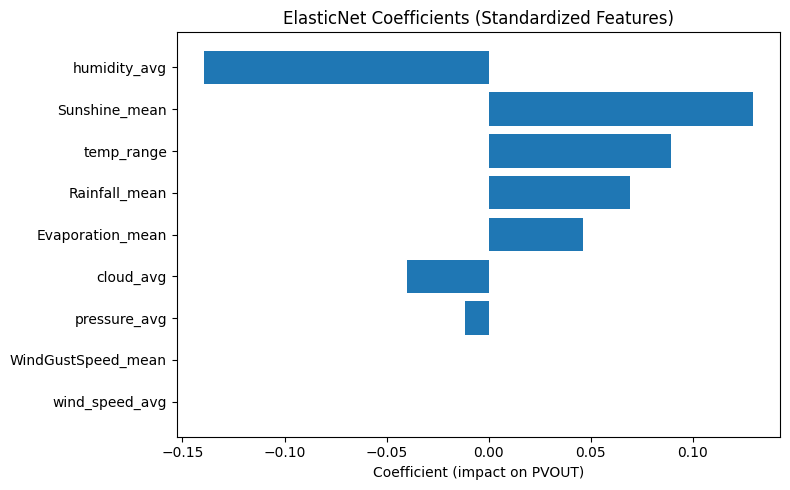

In [15]:
plt.figure(figsize=(8, 5))
plt.barh(
    coef_df["feature"],
    coef_df["coefficient"]
)
plt.gca().invert_yaxis()
plt.title("ElasticNet Coefficients (Standardized Features)")
plt.xlabel("Coefficient (impact on PVOUT)")
plt.tight_layout()
plt.show()


# Save Model

In [19]:
# import joblib
# from datetime import datetime

# ARTIFACT_PATH = "elasticnet_pvout_model.joblib"

# joblib.dump(
#     {
#         "model": best_en_final,      # FITTED pipeline
#         "features": list(X.columns),    # EXACT training order
#         "trained_at": datetime.utcnow().isoformat(),
#         "cv_mae": 0.1342,
#         "cv_r2": 0.7610,
#     },
#     ARTIFACT_PATH
# )

# print("Saved model artifact with feature order")


Saved model artifact with feature order


C:\Users\User\AppData\Local\Temp\ipykernel_11100\2818540187.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at": datetime.utcnow().isoformat(),


In [18]:
# import joblib
# joblib.dump(best_en_final, "elasticnet_pvout_model.joblib")

['elasticnet_pvout_model.joblib']